In [10]:
import numpy as np
import matplotlib.pyplot as plt
from comp2 import dataset, models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import torch
import random
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
import torch.optim as optim
import torch.nn as nn
from sklearn.ensemble import RandomForestRegressor
from string import digits
import re

def setup_seed(seed):
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    return seed


randomseed = setup_seed(9807)


In [11]:
periodic_table = ('H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar',
                  'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br',
                  'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te',
                  'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm',
                  'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn',
                  'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr',
                  'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og', 'Uue')


def indexNumber(path=''):
    kv = []
    nums = []
    beforeDatas = re.findall('\d', path)
    for num in beforeDatas:
        indexV = []
        times = path.count(num)
        if(times > 1):
            if(num not in nums):
                indexs = re.finditer(num, path)
                for index in indexs:
                    iV = []
                    i = index.span()[0]
                    iV.append(num)
                    iV.append(i)
                    kv.append(iV)
            nums.append(num)
        else:
            index = path.find(num)
            indexV.append(num)
            indexV.append(index)
            kv.append(indexV)
    # Sort by numeric position
    indexSort = []
    resultIndex = []
    for vi in kv:
        indexSort.append(vi[1])
    indexSort.sort()
    for i in indexSort:
        for v in kv:
            if(i == v[1]):
                resultIndex.append(v)
    return resultIndex


def get_element(compoundname):
    withoutnum = compoundname.translate(str.maketrans('', '', digits))
    posiofelements = []
    for i in range(len(withoutnum)):
        if withoutnum[i].isupper():
            posiofelements.append(i)
    # print(posiofelements)
    elementsincompund = []
    count = 0
    for j in posiofelements:
        elementsincompund.append(withoutnum[count:j])
        count = j
    elementsincompund.append(
        withoutnum[posiofelements[-1]:])  # Add the last one
    # Remove the first(which is an empty list)
    elementsincompund = elementsincompund[1:]
    return(elementsincompund)


def EleEncoder(com_name):
    name_sub = {}
    ele = get_element(com_name)
    ind = indexNumber(com_name)
    if len(ind) == 0:
        for i in ele:
            name_sub[i] = 1
    elif len(ind) > 1:
        count = 0
        index = []
        while count < len(ind)-1:
            # print(index)
            if ind[count+1][1] == ind[count][1]+1:
                index.append((str(ind[count][0])+str(ind[count+1][0])))
                count += 2
            else:
                index.append((str(ind[count][0])))
                count += 1
        if ind[-1][1] != ind[-2][1]+1:
            index.append(str(ind[-1][0]))
        #print(int(max(index)))

        for i in range(len(ele)):
            name_sub[ele[i]] = int(index[i]) / int(max(index))
    elif len(ind) == 1:
        for i in ele:
            name_sub[i] = 1

    encoder = np.zeros(119)
    for i in name_sub.keys():
        elenum = periodic_table.index(i)
        encoder[elenum] = name_sub[i]

    return encoder.reshape(-1, 1)

In [12]:
load_dict = np.load('originaldata_file.npy', allow_pickle=True).item()

# x = []
# y = []
symbol = {}
pretty_formula = {}
hall = {}
point_group = {}
oxide_type = {}
load_dict['Cs1']['spacegroup']
load_dict['Al2F6']['pretty_formula']
symbol = []
hall = []
point_group = []
pretty_formula = []
crystal_system = []
oxide_type = []
Bulk_modulus = []
Shear_modulus = []

for key in load_dict.keys():
    symbol.append(load_dict[key]['spacegroup']['symbol'])
    hall.append(load_dict[key]['spacegroup']['hall'])
    point_group.append(load_dict[key]['spacegroup']['point_group'])
    crystal_system.append(load_dict[key]['spacegroup']['crystal_system'])
    pretty_formula.append(load_dict[key]['pretty_formula'])
    oxide_type.append(load_dict[key]['oxide_type'])
    Bulk_modulus.append(load_dict[key]['elasticity']['G_Voigt_Reuss_Hill'])
    Shear_modulus.append(load_dict[key]['elasticity']['K_Voigt_Reuss_Hill'])

Symbol = np.array(symbol)
Hall = np.array(hall)
Point_group = np.array(point_group)
Pretty_formula = np.array(pretty_formula)
Crystal_system = np.array(crystal_system)
Oxide_type = np.array(oxide_type)
Bulk_modulus = np.array(Bulk_modulus)
Shear_modulus = np.array(Shear_modulus)

encoder = LabelEncoder()
onehot = OneHotEncoder()
Symbol = encoder.fit_transform(Symbol)
Hall = encoder.fit_transform(Hall)
Point_group = encoder.fit_transform(Point_group)

Crystal_system = encoder.fit_transform(Crystal_system)
Oxide_type = encoder.fit_transform(Oxide_type)


In [13]:
Pretty_formula_encode = []
wrongcomp = []
for i in load_dict.keys():
    try:
        Pretty_formula_encode.append(EleEncoder(i))
    except:
        wrongcomp.append(i)
Pretty_formula_encode = np.array(Pretty_formula_encode)
#print(wrongcomp)
Pretty_formula_encode.shape


(4085, 119, 1)

In [14]:
# from EperAtom
def dataset(valuetype='modulus', index=0, Encoder='LabelEncoder'):
    '''
    valuetype =='modulus', 'eigvalues', 'realvalues'
    Encoder='LabelEncoder', 'EleEncoder'
    '''

    load_dict = np.load('originaldata_file.npy', allow_pickle=True).item()

    symbol = {}
    pretty_formula = {}
    hall = {}
    point_group = {}
    oxide_type = {}
    load_dict['Cs1']['spacegroup']
    load_dict['Al2F6']['pretty_formula']
    symbol = []
    hall = []
    point_group = []
    pretty_formula_encode = []
    wrongcomp = []
    crystal_system = []
    oxide_type = []
    Bulk_modulus = []
    Shear_modulus = []

    for key in load_dict.keys():
        symbol.append(load_dict[key]['spacegroup']['symbol'])
        hall.append(load_dict[key]['spacegroup']['hall'])
        point_group.append(load_dict[key]['spacegroup']['point_group'])
        crystal_system.append(load_dict[key]['spacegroup']['crystal_system'])
        if Encoder == 'LabelEncoder':
            pretty_formula_encode.append(load_dict[key]['pretty_formula'])
        elif Encoder == 'EleEncoder':
            try:
                pretty_formula_encode.append(EleEncoder(key))
            except:
                wrongcomp.append(key)

        oxide_type.append(load_dict[key]['oxide_type'])
        Bulk_modulus.append(load_dict[key]['elasticity']['G_Voigt_Reuss_Hill'])
        Shear_modulus.append(
            load_dict[key]['elasticity']['K_Voigt_Reuss_Hill'])

    Symbol = np.array(symbol)
    Hall = np.array(hall)
    Point_group = np.array(point_group)
    Pretty_formula_encode = np.array(pretty_formula_encode)
    Crystal_system = np.array(crystal_system)
    Oxide_type = np.array(oxide_type)
    Bulk_modulus = np.array(Bulk_modulus)
    Shear_modulus = np.array(Shear_modulus)

    encoder = LabelEncoder()
    Symbol = encoder.fit_transform(Symbol)
    Hall = encoder.fit_transform(Hall)
    if Encoder == 'LabelEncoder':
        Pretty_formula_encode = encoder.fit_transform(Pretty_formula_encode)
    Point_group = encoder.fit_transform(Point_group)
    Crystal_system = encoder.fit_transform(Crystal_system)
    Oxide_type = encoder.fit_transform(Oxide_type)

    # print(Pretty_formula_encode.shape)
    data_0 = []
    count_00 = 0
    for key in load_dict:
        x_0 = [Pretty_formula_encode[count_00],load_dict[key]['energy_per_atom'], load_dict[key]['volume']/load_dict[key]['nsites'],
                Symbol[count_00],
               Hall[count_00], Point_group[count_00],
               Crystal_system[count_00],
               load_dict[key]['formation_energy_per_atom'],
               load_dict[key]['density'], Oxide_type[count_00],
               load_dict[key]['nsites']]
        count_00 += 1

        if valuetype == 'eigvalues':
            # y_0 = [[load_dict[key]['elasticity']['elastic_tensor'][0][0], load_dict[key]['elasticity']['elastic_tensor'][0][1], 0],
            #        [load_dict[key]['elasticity']['elastic_tensor'][0][1],
            #         load_dict[key]['elasticity']['elastic_tensor'][0][0], 0],
            #        [0, 0, load_dict[key]['elasticity']['elastic_tensor'][3][3]]
            #        ]
            y_0 = load_dict[key]['elasticity']['elastic_tensor']
            # print(y_0)
            if np.linalg.eigvals(y_0)[index+1] <= 1e-6:
                y_0 = [0.]
            else:
                y_0 = [np.linalg.eigvals(y_0)[index+1]]

        elif valuetype == 'realvalues':
            if index == 0:
                # DNN 0.60, RFR 0.57
                if load_dict[key]['elasticity']['elastic_tensor'][0][0] <= 1e-6:
                    y_0 = [0.]
                else:
                    y_0 = [load_dict[key]['elasticity']
                           ['elastic_tensor'][0][0]]
            elif index == 1:
                if load_dict[key]['elasticity']['elastic_tensor'][0][1] <= 1e-6:
                    y_0 = [0.]
                else:
                    y_0 = [load_dict[key]['elasticity']
                           ['elastic_tensor'][0][1]]
            elif index == 2:
                if load_dict[key]['elasticity']['elastic_tensor'][3][3] <= 1e-6:
                    y_0 = [0.]
                else:
                    y_0 = [load_dict[key]['elasticity']
                           ['elastic_tensor'][3][3]]
                # print(valuetype)

        elif valuetype == 'modulus':
            if index == 0:
                if load_dict[key]['elasticity']['G_Voigt_Reuss_Hill'] <= 1e-6:
                    y_0 = [0.]
                else:
                    y_0 = [load_dict[key]['elasticity']['G_Voigt_Reuss_Hill']]
            if index == 1:
                if load_dict[key]['elasticity']['K_Voigt_Reuss_Hill'] <= 1e-6:
                    y_0 = [0.]
                else:
                    y_0 = [load_dict[key]['elasticity']['K_Voigt_Reuss_Hill']]

        data_0.append((x_0, y_0))
    data_0[0]

    xx_0 = []
    yy_0 = []
    for i in range(len(data_0)):

        if isinstance(data_0[i][1][0], complex) is False:

            xx_0.append(data_0[i][0])
            yy_0.append(data_0[i][1])
    
    if Encoder == 'EleEncoder':
        xx_0 = np.array(xx_0, dtype=object)
    else:
        xx_0 = np.array(xx_0)
    
    yy_0 = np.array(yy_0)

    # Remove outliers
    yaxis = []
    for i in range(len(yy_0)):
        yaxis.append(yy_0[i][0])

    std_0 = np.std(yaxis)
    mean_0 = np.mean(yaxis)
    lst_0 = []
    count_0 = 0
    for i in range(len(yaxis)):
        count_0 += 1
        if abs(yaxis[i] - mean_0) > std_0 * 2:
            lst_0.append(i)

    yy_0 = np.delete(yy_0, lst_0, axis=0)
    xx_0 = np.delete(xx_0, lst_0, axis=0)

    return xx_0, yy_0


In [15]:

RF_acc = []
DNN_acc = []
parameters = np.array([('modulus', 0), ('modulus', 1)])
name_data = np.array(
    ['Eigvalue 0', 'Eigvalue 1', 'Eigvalue 2', 'C11', 'C12', 'C44'])
for parameter in parameters:
    valuetype_acc = parameter[0]
    index_acc = int(parameter[1])
    xx_acc, yy_acc = dataset(valuetype=valuetype_acc, index=index_acc)
    print(xx_acc[0])
    Result_acc = models(xx_acc, yy_acc, Pca=0,
                        Scaler='StandardScaler')  # no pca
    n_estimators_lst = [2, 5, 10, 15, 20, 25, 40, 50]
    RF_result = []
    for n_estimators in n_estimators_lst:
        accuracy_RF = Result_acc.RandomForestRegression(n_estimators)
        RF_result.append(accuracy_RF)

    best_n = n_estimators_lst[RF_result.index(max(RF_result))]
    highst_acc = max(RF_result)
    print('The best n_estimators is %s, the accuracy is %s' %
          (best_n, highst_acc))
    RF_acc.append(highst_acc)

    epochs = [200]#, 500, 1000, 1500, 2000]#, 3000]  # , 5000]
    DNN_result = []
    for i in epochs:
        accuracy_DNN = Result_acc.DNN(i)
        DNN_result.append(accuracy_DNN)

    best_step = epochs[DNN_result.index(max(DNN_result))]
    highst_acc_DNN = max(DNN_result)
    print('The best epoch is %s, the accuracy is %s' %
          (best_step, highst_acc_DNN))
    DNN_acc.append(highst_acc_DNN)
#plt.plot(RF_acc)

[ 7.02000000e+02 -8.56632760e-01  1.14051805e+02  4.30000000e+01
  1.60000000e+01  2.70000000e+01  0.00000000e+00  3.87696121e-02
  1.93503903e+00  0.00000000e+00  1.00000000e+00]
The best n_estimators is 15, the accuracy is 0.533268619115919
The best epoch is 200, the accuracy is 0.5565278205324617
[ 7.02000000e+02 -8.56632760e-01  1.14051805e+02  4.30000000e+01
  1.60000000e+01  2.70000000e+01  0.00000000e+00  3.87696121e-02
  1.93503903e+00  0.00000000e+00  1.00000000e+00]
The best n_estimators is 40, the accuracy is 0.8479799737040611
The best epoch is 200, the accuracy is 0.8380369323392467


numpy.float64

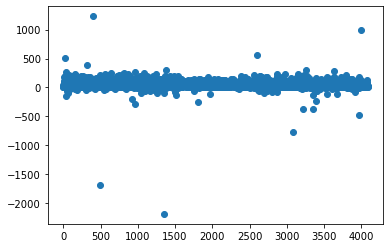

In [16]:
plt.scatter(np.linspace(0, Bulk_modulus.shape[0], Bulk_modulus.shape[0]), Bulk_modulus)
type(Bulk_modulus[0])

In [17]:
lll = np.linspace(0, 100, 100)
ccc = np.clip(lll, 70, 90, out= None)
ccc
np.std(lll)
from scipy import stats
def get_trunc_mutation(data, sigma ,min, max):
    mu = data
    trunc_mutation = stats.truncnorm((min - mu) / sigma, (max - mu) / sigma, loc=data, scale=sigma)
    trunc_mutation_data = trunc_mutation.rvs(1)
    return trunc_mutation_data[0]

for i in range(1):
    print(type(round(get_trunc_mutation(5, 1, 4, 6))))

<class 'int'>


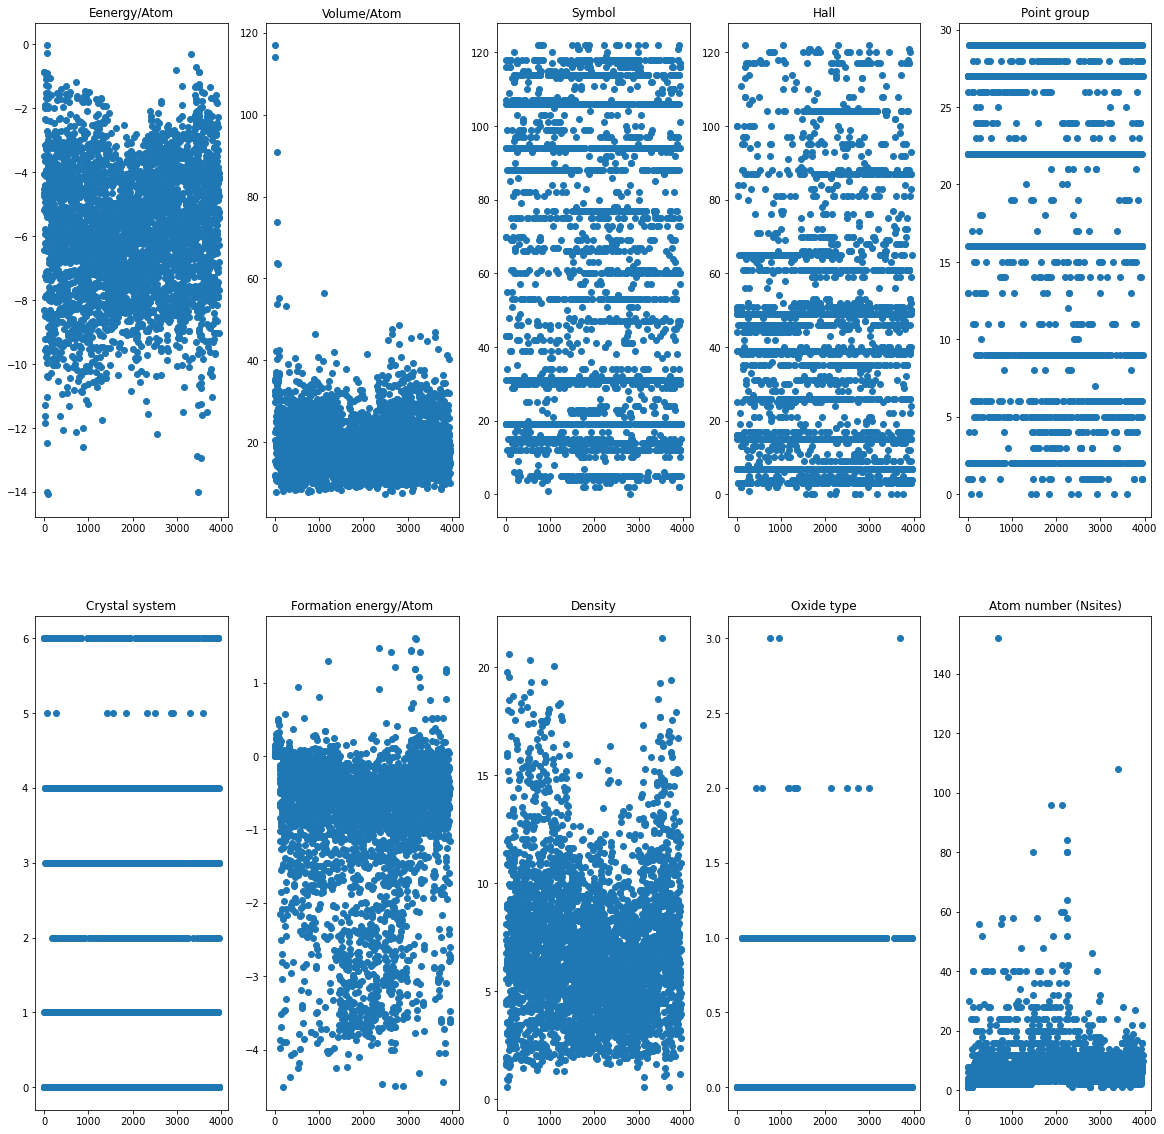

In [26]:
xx, yy = dataset(Encoder='LabelEncoder')
figname = ['Eenergy/Atom', 'Volume/Atom', 'Symbol', 'Hall','Point group', 'Crystal system',
'Formation energy/Atom', 'Density', 'Oxide type', 'Atom number (Nsites)']
type(xx[:,2][0])
plt.figure(figsize=(20, 20))
for i in range(1, xx.shape[1]):
    plt.subplot(2, 5, i)
    plt.scatter(np.linspace(0, xx.shape[0], xx.shape[0]), xx[:, i])
    plt.title('%s'%(figname[i-1]))